# Step 1: Import Libraries

In [1]:
# ========================
# Core Libraries
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ========================
# Preprocessing & Splitting
# ========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ========================
# Deep Learning (TensorFlow/Keras)
# ========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ========================
# Evaluation Metrics
# ========================
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    f1_score, 
    precision_recall_curve
)

# ========================
# Handling Imbalance (Safe Import)
# ========================
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    SMOTE = None
    print("⚠️ imbalanced-learn not installed. Install it with: pip install imbalanced-learn")

# ========================
# Optional Feature Engineering
# ========================
try:
    from geopy.distance import geodesic
except ImportError:
    geodesic = None
    print("⚠️ geopy not installed. Install it with: pip install geopy")


2025-08-17 06:21:29.870755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755411690.079136      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755411690.142829      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


⚠️ imbalanced-learn not installed. Install it with: pip install imbalanced-learn


# Step 2: Load Dataset

In [2]:
# Kaggle input path
train_data = pd.read_csv('/kaggle/input/credit-card-fraud-detection/fraudTrain.csv')
test_data  = pd.read_csv('/kaggle/input/credit-card-fraud-detection/fraudTest.csv')

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Train data shape: (1296675, 23)
Test data shape: (555719, 23)


In [18]:
train_data.head(5)

,Unnamed: 0,cc_num,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,hour,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,0,2703186189652095,-0.407826,36.0788,-81.1781,3495.0,36.011293,-82.048315,0,0,...,False,False,False,True,False,False,False,False,False,False
1,1,630423337322,0.230039,48.8878,-118.2105,149.0,49.159047,-118.186462,0,0,...,False,False,False,False,False,False,False,False,False,False
2,2,38859492057661,0.934149,42.1808,-112.2620,4154.0,43.150704,-112.154481,0,0,...,False,False,False,False,False,False,False,False,False,True
3,3,3534093764340240,-0.158132,46.2306,-112.1138,1939.0,47.034331,-112.561071,0,0,...,False,False,False,False,False,False,False,False,False,True
4,4,375534208663984,-0.177094,38.4207,-79.4629,99.0,38.674999,-78.632459,0,0,...,False,False,False,False,True,False,False,False,False,True


# Step 3: Handle Missing Values

In [3]:
# Impute numerical columns with mean
numerical_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']
imputer = SimpleImputer(strategy='mean')

train_data[numerical_cols] = imputer.fit_transform(train_data[numerical_cols])
test_data[numerical_cols]  = imputer.transform(test_data[numerical_cols])


# Step 4: Feature Engineering

In [4]:
def preprocess_data(data):
    # Extract temporal features
    data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
    data['hour'] = data['trans_date_trans_time'].dt.hour
    data['day_of_week'] = data['trans_date_trans_time'].dt.dayofweek
    data['day_of_month'] = data['trans_date_trans_time'].dt.day
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    data['season'] = data['trans_date_trans_time'].dt.month % 12 // 3 + 1
    
    # Distance feature
    data['distance'] = data.apply(
        lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1
    )
    
    # Drop identifiers & PII
    data.drop(columns=['trans_date_trans_time','first','last','street','city',
                       'state','zip','job','dob','trans_num','unix_time','merchant'], inplace=True)
    
    # One-hot encode
    data = pd.get_dummies(data, columns=['category','gender'], drop_first=True)
    
    # Scale transaction amount
    scaler = StandardScaler()
    data['amt'] = scaler.fit_transform(data[['amt']])
    
    return data

train_data = preprocess_data(train_data)
test_data  = preprocess_data(test_data)


# Step 5: Split Data

In [5]:
X_train = train_data.drop(columns=['is_fraud'])
y_train = train_data['is_fraud']

X_test = test_data.drop(columns=['is_fraud'])
y_test = test_data['is_fraud']


# Step 6: Handle Class Imbalance (ClassWeight)

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Check distribution
print("Before balancing:", y_train.value_counts())

# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

# Convert to dict {class: weight}
class_weight = dict(zip(classes, weights))
print("Class Weights:", class_weight)


Before balancing: is_fraud
0    1289169
1       7506
Name: count, dtype: int64
Class Weights: {0: 0.5029111776656126, 1: 86.37589928057554}


# Step 7: Build BiLSTM Model

In [10]:
# BiLSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [11]:
# Compile
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Step 8: Train Model

In [12]:

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint     = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# 🔹 Class weights
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes, weights))
print("Class Weights:", class_weight)


Class Weights: {0: 0.5029111776656126, 1: 86.37589928057554}


In [14]:
# Train BiLSTM
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weight
)


Epoch 1/50
4053/4053 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.9504 - loss: 0.1541 - val_accuracy: 0.9312 - val_loss: 0.1527 - learning_rate: 2.0000e-04
Epoch 2/50
4053/4053 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.9447 - loss: 0.1425 - val_accuracy: 0.9488 - val_loss: 0.1335 - learning_rate: 2.0000e-04
Epoch 3/50
4053/4053 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.9464 - loss: 0.1510 - val_accuracy: 0.9736 - val_loss: 0.0902 - learning_rate: 2.0000e-04
Epoch 4/50
4053/4053 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.9466 - loss: 0.1369 - val_accuracy: 0.9507 - val_loss: 0.1216 - learning_rate: 2.0000e-04
Epoch 5/50
4053/4053 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.9503 - loss: 0.1379 - val_accuracy: 0.9525 - val_loss: 0.1127 - learning_rate: 2.0000e-04
Epoch 6/50
4053/4053 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.9495 - loss: 0.1342 - val_accuracy: 0.9535 - val_loss: 0.1150 - learning_rate: 2.0000e-04
Epoch 7/50
4053/4053 ━━━━━━━━━━━━━━━━━━━

# Step 9: Evaluation

17367/17367 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.11      0.88      0.20      2145

    accuracy                           0.97    555719
   macro avg       0.56      0.93      0.59    555719
weighted avg       1.00      0.97      0.98    555719

Confusion Matrix:
[[538840  14734]
 [   263   1882]]
AUC-ROC: 0.9254
F1-score: 0.2006


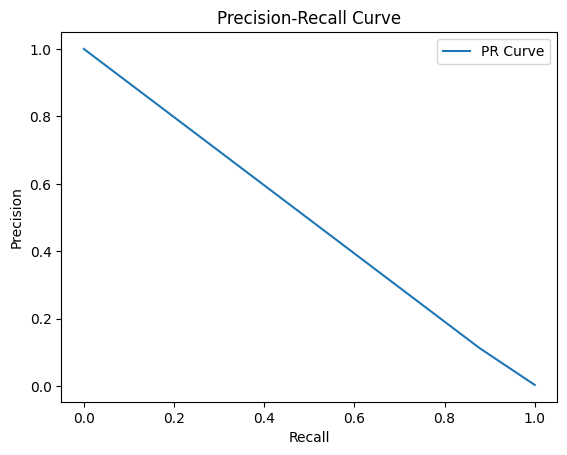

In [17]:
# Predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Reports
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Metrics
auc_roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"F1-score: {f1:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.title("Precision-Recall Curve")
plt.show()